CMSC320 Final Project <br>
Counter Strike: Global Offensive esports statistic analysis <br>
Group Members: Jeff Rosen, Michael Rosen

Counter Strike: Global Offensive (commonly abbreviated as CS:GO) is a massively popular competitive multiplayer video game with a thriving eSports community. eSports popularity is growing at an unprecedented rate with CS:GO at the forefront. Teams from many countries compete against each other in organized tornaments hosted at various venues around the world.<br><br>****TALK ABOUT OUR MOTIVATION BEHIND ANALYZING SPORTS SCORES and what we can get out of it*****We performed data analysis on statistics such as match wins/losses, kill/death ratios, and kill differentials. Our data is of an international scope. All of our data was scraped and parsed from HLTV, one the communities most regarded media groups.<br><br>Data can be found here: HLTV.org/Stats. <br> <br>
We used Python's built-in functionality to send HTTP requests that allowed us to retrieve raw HTML table data. Beautiful Soup scraped the data we requested and generated a highly usuable Pandas dataframe. We had to resort to manually using regex to pull the country names from each team since Beautiful Soup wasn't able to parse it for us. The problem was that HLTV's table presented country data in the form of a flag image instead of plain text. Fortunately, the alt property of the HTML img tags contained the country name text.<br><br>We performed some basic preliminary dataframe sanitation below. Most notably, we removed the team "Tyloo" since they only play exclusively with low performing no name Chinese teams. This anomaly caused massive skews in our data and ruined the integrity of some of our data analyses.

Here we are getting a seperate dataframe for the players in each of the top ten teams. hltv conviently has a stat page that has all of the players. We use beautiful soup to get the data and make it pretty. We filtered out the long list of players from the list of top 10 ranked teams then sorted based on the team name so all the players from the same team are grouped together.

In [1]:
# Import declarations
import math
import re as re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from sklearn import svm
from sklearn.model_selection import cross_val_score

# Get the data
r = requests.get("https://www.hltv.org/stats/teams")

# Create a pandas with pulled data
root = bs(r.content, "html.parser") 
root.prettify()
table = (str)(root.find("table"))
teams = pd.read_html(table, header=0)[0]

# Pull the country data out of the table and put into our dataframe
table = table.strip("\\n")
countries = (re.findall('title="(.+)"/>', table))
teams['Country'] = pd.Series(countries)

# Clean up columns
teams.columns = ['Team', 'Maps', 'K/D Differential', 'K/D', 'Rating', 'Country']
teams = teams[['Team', 'Country', 'Maps', 'K/D Differential', 'K/D', 'Rating']]

# Delete Tyloo from dataframe for reasons mentioned above
teams = teams.drop([0])

# Get a series with all team names
teamlist = teams[teams.columns[0]]

# Display resultant panda
teams

,Team,Country,Maps,K/D Differential,K/D,Rating
1,Space Soldiers,Turkey,607,5091,1.10,1.07
2,FaZe,Europe,439,2124,1.06,1.06
3,NiP,Sweden,1232,11763,1.12,1.06
4,Kinguin,Poland,542,3292,1.07,1.05
5,Astralis,Denmark,445,3550,1.09,1.05
6,Luminosity,Brazil,571,3868,1.08,1.05
7,G2,France,653,1699,1.03,1.05
8,TSM,Denmark,504,2863,1.07,1.04
9,Titan,France,484,1269,1.03,1.04
10,OpTic,North America,465,2177,1.06,1.04


Next we performed a process similar to the one above to construct a dataframe containing information of the players in each of the top ten teams. HLTV convieniently provided us with a page listing all professional players. We used Beautiful Soup convert the raw HTML data into a easily workable pandas dataframe. We filtered out all of the players that weren't in HLTV's top 10 ranked teams list. Finally, we sorted the dataframe by team name so that players from the same team get grouped together.

In [2]:
# Get the data
r = requests.get("https://www.hltv.org/stats/players")

# Create a pandas with pulled data
root = bs(r.content, "html.parser") 
root.prettify()

# Pull the player data out of the table and put into our dataframe
table = (str)(root.find("table"))
players = pd.read_html(table, header=0)[0]

# An array containing a list of top 10 teams (according to HLTV's critically acclaimed ranking system)
topTeams = ['SK', 'FaZe', 'Astralis', 'NiP', 'Cloud9', 'G2', 'North', 'Virtus.pro', 'fnatic', 'Liquid']

# Discard player information for anyone not listed in the top 10 teams
players = players[players['Team'].isin(topTeams)]

players = players.sort_values('Team')

# Display resultant panda
players


,Player,Team,Maps,K/D Diff,K/D,Rating1.0
221,Xyp9x,Astralis,1185,1532,1.08,1.03
17,device,Astralis,1011,3950,1.24,1.16
122,Kjaerbye,Astralis,889,1707,1.11,1.07
285,gla1ve,Astralis,851,345,1.02,1.00
68,dupreeh,Astralis,1128,2762,1.14,1.10
102,autimatic,Cloud9,649,1302,1.11,1.08
176,RUSH,Cloud9,673,876,1.08,1.04
114,tarik,Cloud9,750,1280,1.10,1.07
107,Skadoodle,Cloud9,827,2323,1.19,1.08
111,Stewie2K,Cloud9,620,961,1.09,1.08


We made a graph that is the kill death ratio for each country. The data has been standardized so that we can see more clearly which teams have better kill death ratios and who have worse. From below plot we can see that Russia has been struggling, while countries like Turkey and Sweden have been doing very well. As shown by the print statement of the average k/d of the teams it is above 1 this is because we have only have the data for the upper echelon of teams from their countries. Countries without teams in the upper 30 of k/d are not represented.

Average kill/death ratio of teams given:  1.0460119047619048


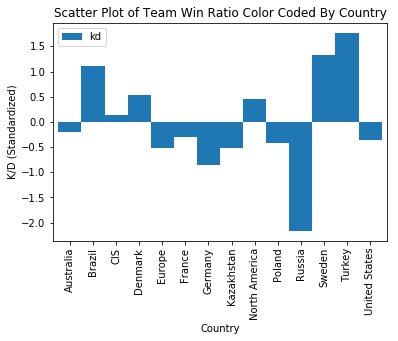

In [3]:
g = teams.groupby("Country")

#Get the mean and standard deviation and find the normalization of the data.
kd = g.mean()['K/D']
avg = kd.mean()
std = kd.std()
normalized_kd = []
for c in kd:
    normalized_kd.append((c-avg)/std)
    
#Make dataframe with newly made normalized data and teams
ts = teams['Country'].sort_values().unique()
temp = pd.DataFrame({'teams': ts, 'kd': normalized_kd})

print("Average kill/death ratio of teams given: ", avg)

#Make the plot of the normalized data vs team
ax = temp.plot(kind='bar',x='teams',y='kd', title='Scatter Plot of Team Win Ratio Color Coded By Country', width = 1)
ax.set_xlabel('Country')
ax.set_ylabel('K/D (Standardized)')
plt.show()

For each of the top 10 ranked teams we scrape their match record based on each year to get their win rate for each year. We then delete useless columns and make the dataframe more readable.  

In [4]:
#https://www.hltv.org/stats/teams/matches/6137/SK

masterDF = pd.DataFrame()
i = 0

topTeamCountries = ['Brazil', 'EU', 'Denmark', 'Sweden', 'North America', 'France', 'Denmark', 'Russia', 'Sweden', 'North America']

topTeamMatches = ['https://www.hltv.org/stats/teams/matches/6137/SK', 'https://www.hltv.org/stats/teams/matches/6667/FaZe', \
                     'https://www.hltv.org/stats/teams/matches/6665/Astralis', 'https://www.hltv.org/stats/teams/matches/4411/NiP', \
                    'https://www.hltv.org/stats/teams/matches/5752/Cloud9', 'https://www.hltv.org/stats/teams/matches/5995/G2', \
                   'https://www.hltv.org/stats/teams/matches/7533/North?startDate=2017-01-01&endDate=2017-12-31', 'https://www.hltv.org/stats/teams/matches/5378/Virtus.pro', \
                   'https://www.hltv.org/stats/teams/matches/4991/fnatic', 'https://www.hltv.org/stats/teams/matches/5973/Liquid']
for team in topTeamMatches :
    
    r = requests.get(team)
    root = bs(r.content, "html.parser") 
    root.prettify()
    table = (str)(root.find("table"))
    SK = pd.read_html(table, header=0)[0]
    SK.columns = ['Date', 'Event', 'Opponent', 'Map', 'Rating', 'W/L', 'Outcome']
    SK.loc[SK.Outcome == 'W', 'Outcome'] = 1
    SK.loc[SK.Outcome == 'L', 'Outcome'] = 0
    SK.loc[SK.Outcome == 'T', 'Outcome'] = 0 #WE NEED TO THROW OUT TIES!!!
    SK['Outcome'] = SK['Outcome'].astype(str).astype(int)
    SK['Event'] = SK['Event'].astype(str)
    SK['Date'] = pd.to_datetime(SK['Date'])
    SK['Year'] = SK['Date'].dt.year
    SK['Team'] = topTeams[i]
    masterDF = masterDF.append(SK)
    i += 1
    
masterDF = masterDF.reset_index(drop=True)
masterDF = masterDF.drop(['Event', 'Opponent'], axis=1)
masterDF = masterDF.rename(index=str, columns={"Map" : "Opponent", "Rating" : "Map"})
cols = masterDF.columns.tolist()
cols = cols[-1:] + cols[:-1]
masterDF = masterDF[cols]
masterDF

,Team,Date,Opponent,Map,W/L,Outcome,Year
0,SK,2017-10-12,FaZe,Train,19 - 16,1,2017
1,SK,2017-10-12,FaZe,Mirage,16 - 9,1,2017
2,SK,2017-10-12,FaZe,Overpass,16 - 11,1,2017
3,SK,2017-10-12,FaZe,Inferno,13 - 16,0,2017
4,SK,2017-09-12,Misfits,Overpass,16 - 1,1,2017
5,SK,2017-09-12,Misfits,Cobblestone,16 - 6,1,2017
6,SK,2017-06-12,Misfits,Cache,16 - 7,1,2017
7,SK,2017-06-12,NRG,Cache,16 - 9,1,2017
8,SK,2017-06-12,NiP,Overpass,16 - 9,1,2017
9,SK,2017-05-12,OpTic,Mirage,14 - 16,0,2017


fill in words. limited years to 2012 because NiP is only team still around in top 10 in all the years. Talk about print statements of NiP winrate. NiP had a absolutely legendary 87-0 win streak in 2012 making their win percentage 98 percent. Clearly by far the best team in that year. Talk about teams showing up mid plot, teams have just been formed or same team joined new team orginization. Maybe do analysis of individual teams and their rise or fall (SK (Grey) steadily grew from ~43 to ~70 from 2013 to 2017). They went through roster changes that worked out well.

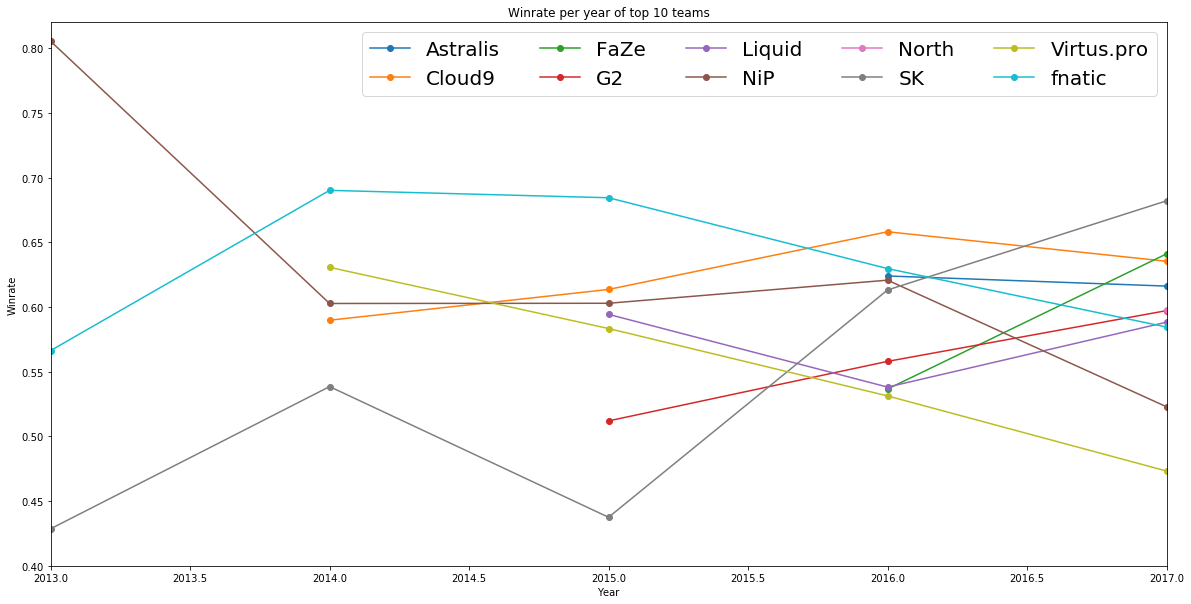

NiP winrate in 2012 :  0.984375
NiP winrate in 2013 :  0.8053435114503816
NiP winrate in 2014 :  0.6026785714285714
NiP winrate in 2015 :  0.6028368794326241
NiP winrate in 2016 :  0.6206896551724138
NiP winrate in 2017 :  0.5228426395939086


In [5]:
#Get Outcome groups for Team, Year
chanz = masterDF.groupby(['Team','Year'])['Outcome'].mean()
cha = chanz.to_frame()
cha['o'] = chanz.index.get_level_values('Team')
cha['f'] = chanz.index.get_level_values('Year')

cha = cha.reset_index(drop=True)
cha = cha.rename(columns={'Outcome': 'Outcome', 'o': 'Team', 'f': 'Year'})

#Group by team and get unique
ts = cha.groupby('Team')
names = ts['Team'].unique()
flat_names = [item for sublist in names for item in sublist]

#Format plot
plt.figure(figsize=(20,10))
plt.xlim(2013,2017)
plt.ylim(.4, .82)
plt.title("Winrate per year of top 10 teams")
plt.ylabel('Winrate')
plt.xlabel('Year')

#Plot for each team
for k,v in ts:
    plt.plot(v['Year'], v['Outcome'],marker='o')
    
plt.legend(flat_names, ncol=5, prop={'size': 20})

plt.show()

#Print out significant data about NiP
wrs = ts.get_group('NiP')['Outcome'].tolist()
years = ['2012','2013','2014','2015','2016','2017']

for i in range(0,6):
    print("NiP winrate in", years[i], ": ", wrs[i])

Got the means and maxes of the K/D Differential for each team. Made bar graph showing the how the best player on the team did compared to all of the players on the team. Print the means of the K/D Differential and the max K/D Differential. Notice how one player usually does a lot better than the rest. This is usually because the teams try to put their "star" player in the best senarios to carry the game while sacrificing some of their own stats to either facilitate kills for the other player or to hold a more volatile position on the map where they are less likely to do well. We then printed out the percentage of how much better the star player did than the rest of the team. Notice how they are usually around mid 50%'s with North having the lowest by far of 26.83%. This shows that North is a team that each player does well and has no real "star" player but instead 3-4 players per game that are doing well.


Means of K/D Difference per team
 Team
Astralis      2059.2
Cloud9        1348.4
FaZe          1931.4
G2            2184.4
Liquid         816.4
NiP           2667.4
North          703.6
SK            1910.0
Virtus.pro    1170.4
fnatic        1606.8
Name: K/D Diff, dtype: float64

Maxs of K/D Difference per team
 Team
Astralis      3950
Cloud9        2323
FaZe          3962
G2            4852
Liquid        1502
NiP           5009
North         2622
SK            3715
Virtus.pro    2192
fnatic        3006
Name: K/D Diff, dtype: int64


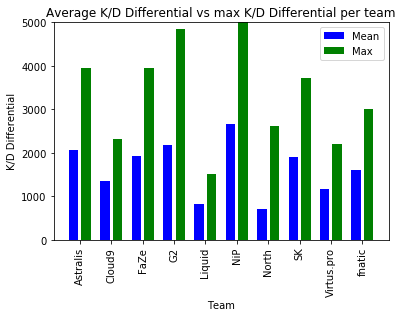

How much better each teams best player did versus average of players on the team
Astralis : 52.13 %
Cloud9 : 58.05 %
FaZe : 48.75 %
G2 : 45.02 %
Liquid : 54.35 %
NiP : 53.25 %
North : 26.83 %
SK : 51.41 %
Virtus.pro : 53.39 %
fnatic : 53.45 %


In [6]:
means = []
maxs = []
teams = players['Team'].sort_values().unique()
stuff = players.groupby('Team')

#Get the means and maxes from the groups and format the columns
means = stuff.mean()
maxs = stuff.max()
means.columns = ['Maps', 'K/D Diff', 'K/D', 'Rating']
maxs.columns = ['Player', 'Maps', 'K/D Diff', 'K/D', 'Rating']

#Print the data I got
print("Means of K/D Difference per team\n", means['K/D Diff'])
print("\nMaxs of K/D Difference per team\n", maxs['K/D Diff'])

#Plot the bar graph with means as blue and maxs as green
ax = plt.subplot(111)
ax.bar([.8,1.8,2.8,3.8,4.8,5.8,6.8,7.8,8.8,9.8], means['K/D Diff'], width=0.3,color='b',align='center')
ax.bar([1.2,2.2,3.2,4.2,5.2,6.2,7.2,8.2,9.2,10.2], maxs['K/D Diff'],width=0.3,color='g',align='center')
plt.xticks([1,2,3,4,5,6,7,8,9,10], teams, rotation='vertical')

#Graph formatting
ax.set_ylim([0, 5000])
ax.legend(['Mean', 'Max'])
plt.title("Average K/D Differential vs max K/D Differential per team")
plt.ylabel('K/D Differential')
plt.xlabel('Team')

plt.show()

me = means['K/D Diff'].tolist()
ma = maxs['K/D Diff'].tolist()

#Print the differences in the star player vs mean players
print("How much better each teams best player did versus average of players on the team")
for i in range(len(me)):
    c = (me[i]/ma[i])*100
    print(teams[i], ": %.2f" %c, "%")


Machine learning section: Do countries or teams winrate over the years and predict years to come.

In [7]:
# Lump groups of countries together for machine learning purposes
europe = masterDF[(masterDF.Team == 'Astralis') | (masterDF.Team == 'North') | (masterDF.Team == 'G2') | (masterDF.Team == 'FaZe')]
america = masterDF[(masterDF.Team == 'C9') | (masterDF.Team == 'Liquid') | (masterDF.Team == 'SK')]
sweden = masterDF[(masterDF.Team == 'NiP') | (masterDF.Team == 'fnatic')]

# Create SKlearn machine learning classifier
linearsvm = svm.SVC()
europesvm = cross_val_score(linearsvm, europe.Year.values.reshape((1717,1)), europe.Outcome, cv=10)
americasvm = cross_val_score(linearsvm, america.Year.values.reshape((1464,1)), america.Outcome, cv=10)
swedensvm = cross_val_score(linearsvm, sweden.Year.values.reshape((2302,1)), sweden.Outcome, cv=10)

# Perform a 10 point cross validation on Europe group
print ("Linear SVM 10 Point Cross Validation On Europe Data")
print(europesvm)
print ("\n")

# Perform a 10 point cross validation on America group
print ("Linear SVM 10 Point Cross Validation On America Data")
print(americasvm)
print ("\n")

# Perform a 10 point cross validation on Sweden group
print ("Linear SVM 10 Point Cross Validation On Sweden Data")
print(swedensvm)
print("\n")

print ("Linear SVM Cross Mean and Standard Error For Europe Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (europesvm.mean(), europesvm.std() * 2))
print("\n")

print ("Linear SVM Cross Mean and Standard Error For America Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (americasvm.mean(), americasvm.std() * 2))
print("\n")

print ("Linear SVM Cross Mean and Standard Error For Sweden Data")
print("Accuracy: %0.2f (+/- %0.2f)" % (swedensvm.mean(), swedensvm.std() * 2))

ValueError: cannot reshape array of size 1721 into shape (1717,1)

With our data we noticed that top teams that are from more remote areas have statistics that overshadow the top teams in the world. This is because they are constantly playing versus weaker opponents. Sweden is has been and is still a powerhouse in the world scene with popular team Virtus.Pro from Russia being on a large decline. North American teams are still far from the top European teams. NiP used to be the best team by a large margin with an outstanding 98% winrate and a stranglehold on the whole CSGO scene. Now the best team is nowhere as dominant as 2012 NiP. Most teams try to facilitate one player to do the best and carry them to victory, we took a look at how much the best player on the team out performs the average of the whole team. Most teams have a player that does ~50% better than the other players.

The data on hltv.org was originally taken for data analysis and we were able to scrape it to do some more unique plots and approximation on our own. We used what we know from data curation, parsing, management, exploratory data analysis, machine learning, and gave insights on data. We used all these skills to give analysis on the data we got on Counter Strike: Global Offensive's thriving eSports scene.